# Generative Adversarial Network(GAN) using Keras

Credit Goes to

https://medium.datadriveninvestor.com/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3



GAN is an unsupervised deep learning algorithm where we have a Generator pitted against an adversarial network called Discriminator.
Generator generates counterfeit currency. Discriminators are a team of cops trying to detect the counterfeit currency. Counterfeiters and cops both are trying to beat each other at their game.
Both Generator and Discriminator will be multi-layer perceptrons(MLP)

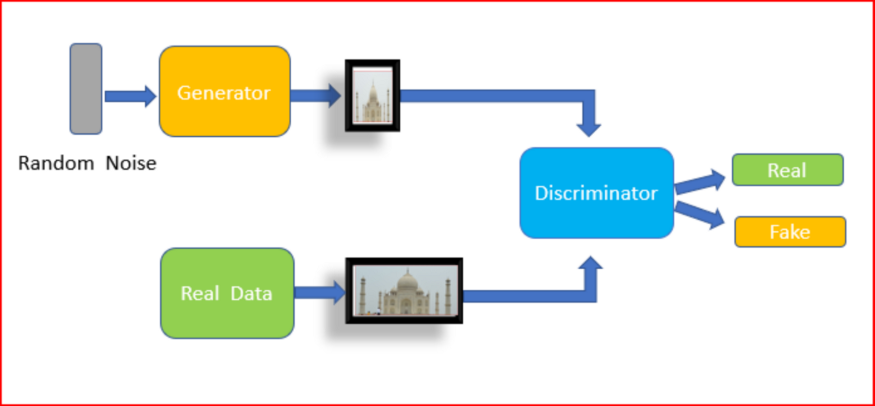

Generator’s objective will be to generate data that is very similar to the training data. Data generated from Generator should be indistinguishable from the real data.

Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator.

GAN will use the MNIST data and identify the latent feature representation for generating digits. At the end we will see how the Generators are able to generate real-looking MNIST digits.

Let’s import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

Loading the data from mnist dataset. we create a function load_data() function

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)


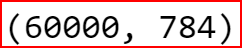

We will use Adam optimizer as it is computationally efficient and has very little memory requirement. Adam is a combination of Adagrad and RMSprop.

In [3]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

Let’s visualize the GAN architecture that we plan to build

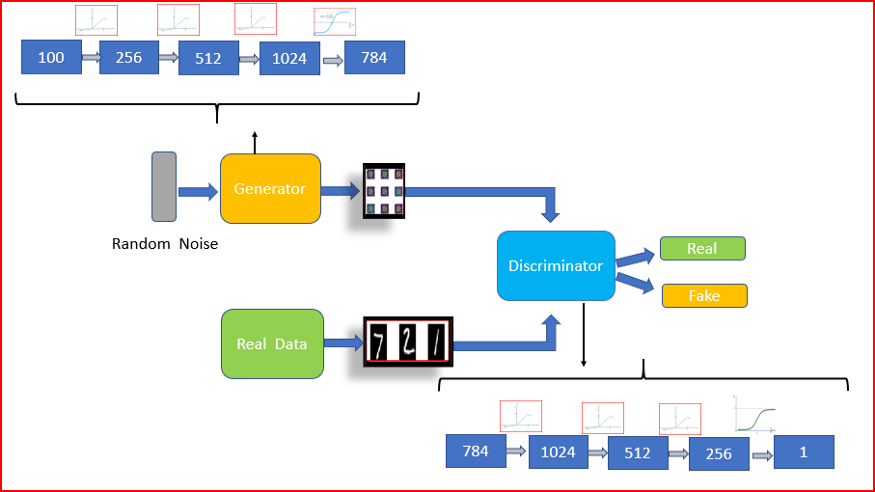

We create Generator which uses MLP using simple dense layers activated by tanh

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator
    
g=create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We now create the Discriminator which is also MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator.

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
    
d =create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator.

We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
    
gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

We finally start to train GAN. We will first have the full code for training GAN and then break it step by step for understanding how the training happens

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1


100%|██████████| 128/128 [00:13<00:00,  9.25it/s]


Epoch 2


100%|██████████| 128/128 [00:10<00:00, 12.69it/s]


Epoch 3


100%|██████████| 128/128 [00:10<00:00, 11.85it/s]


Epoch 4


100%|██████████| 128/128 [00:10<00:00, 12.35it/s]


Epoch 5


100%|██████████| 128/128 [00:10<00:00, 12.78it/s]


Epoch 6


100%|██████████| 128/128 [00:10<00:00, 12.51it/s]


Epoch 7


100%|██████████| 128/128 [00:09<00:00, 13.20it/s]


Epoch 8


100%|██████████| 128/128 [00:10<00:00, 12.70it/s]


Epoch 9


100%|██████████| 128/128 [00:10<00:00, 12.69it/s]


Epoch 10


100%|██████████| 128/128 [00:10<00:00, 12.65it/s]


Epoch 11


100%|██████████| 128/128 [00:10<00:00, 12.74it/s]


Epoch 12


100%|██████████| 128/128 [00:10<00:00, 12.52it/s]


Epoch 13


100%|██████████| 128/128 [00:10<00:00, 12.71it/s]


Epoch 14


100%|██████████| 128/128 [00:10<00:00, 12.24it/s]


Epoch 15


100%|██████████| 128/128 [00:10<00:00, 12.37it/s]


Epoch 16


100%|██████████| 128/128 [00:10<00:00, 12.26it/s]


Epoch 17


100%|██████████| 128/128 [00:10<00:00, 12.09it/s]


Epoch 18


100%|██████████| 128/128 [00:10<00:00, 12.63it/s]


Epoch 19


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 20


100%|██████████| 128/128 [00:10<00:00, 12.42it/s]


Epoch 21


100%|██████████| 128/128 [00:10<00:00, 12.18it/s]


Epoch 22


100%|██████████| 128/128 [00:10<00:00, 12.60it/s]


Epoch 23


100%|██████████| 128/128 [00:10<00:00, 12.20it/s]


Epoch 24


100%|██████████| 128/128 [00:10<00:00, 12.14it/s]


Epoch 25


100%|██████████| 128/128 [00:10<00:00, 11.99it/s]


Epoch 26


100%|██████████| 128/128 [00:11<00:00, 11.59it/s]


Epoch 27


100%|██████████| 128/128 [00:10<00:00, 11.71it/s]


Epoch 28


100%|██████████| 128/128 [00:10<00:00, 11.69it/s]


Epoch 29


100%|██████████| 128/128 [00:10<00:00, 11.79it/s]


Epoch 30


100%|██████████| 128/128 [00:10<00:00, 11.85it/s]


Epoch 31


100%|██████████| 128/128 [00:11<00:00, 11.58it/s]


Epoch 32


100%|██████████| 128/128 [00:10<00:00, 11.67it/s]


Epoch 33


100%|██████████| 128/128 [00:10<00:00, 11.80it/s]


Epoch 34


100%|██████████| 128/128 [00:10<00:00, 11.82it/s]


Epoch 35


100%|██████████| 128/128 [00:10<00:00, 11.81it/s]


Epoch 36


100%|██████████| 128/128 [00:10<00:00, 12.00it/s]


Epoch 37


100%|██████████| 128/128 [00:10<00:00, 12.23it/s]


Epoch 38


100%|██████████| 128/128 [00:10<00:00, 11.94it/s]


Epoch 39


100%|██████████| 128/128 [00:10<00:00, 12.05it/s]


Epoch 40


100%|██████████| 128/128 [00:10<00:00, 12.10it/s]


Epoch 41


100%|██████████| 128/128 [00:10<00:00, 11.90it/s]


Epoch 42


100%|██████████| 128/128 [00:10<00:00, 11.72it/s]


Epoch 43


100%|██████████| 128/128 [00:10<00:00, 12.12it/s]


Epoch 44


100%|██████████| 128/128 [00:10<00:00, 12.01it/s]


Epoch 45


100%|██████████| 128/128 [00:10<00:00, 11.97it/s]


Epoch 46


100%|██████████| 128/128 [00:10<00:00, 11.90it/s]


Epoch 47


100%|██████████| 128/128 [00:10<00:00, 12.08it/s]


Epoch 48


100%|██████████| 128/128 [00:10<00:00, 11.97it/s]


Epoch 49


100%|██████████| 128/128 [00:10<00:00, 11.93it/s]


Epoch 50


100%|██████████| 128/128 [00:10<00:00, 12.56it/s]


Epoch 51


100%|██████████| 128/128 [00:10<00:00, 12.12it/s]


Epoch 52


100%|██████████| 128/128 [00:10<00:00, 12.05it/s]


Epoch 53


100%|██████████| 128/128 [00:10<00:00, 12.10it/s]


Epoch 54


100%|██████████| 128/128 [00:10<00:00, 11.67it/s]


Epoch 55


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 56


100%|██████████| 128/128 [00:10<00:00, 12.22it/s]


Epoch 57


100%|██████████| 128/128 [00:10<00:00, 12.34it/s]


Epoch 58


100%|██████████| 128/128 [00:10<00:00, 12.38it/s]


Epoch 59


100%|██████████| 128/128 [00:10<00:00, 12.18it/s]


Epoch 60


100%|██████████| 128/128 [00:10<00:00, 11.94it/s]


Epoch 61


100%|██████████| 128/128 [00:10<00:00, 12.27it/s]


Epoch 62


100%|██████████| 128/128 [00:10<00:00, 12.66it/s]


Epoch 63


100%|██████████| 128/128 [00:10<00:00, 12.48it/s]


Epoch 64


100%|██████████| 128/128 [00:10<00:00, 12.37it/s]


Epoch 65


100%|██████████| 128/128 [00:09<00:00, 12.85it/s]


Epoch 66


100%|██████████| 128/128 [00:10<00:00, 12.61it/s]


Epoch 67


100%|██████████| 128/128 [00:10<00:00, 12.79it/s]


Epoch 68


100%|██████████| 128/128 [00:10<00:00, 12.58it/s]


Epoch 69


100%|██████████| 128/128 [00:09<00:00, 12.91it/s]


Epoch 70


100%|██████████| 128/128 [00:09<00:00, 12.81it/s]


Epoch 71


100%|██████████| 128/128 [00:10<00:00, 11.92it/s]


Epoch 72


100%|██████████| 128/128 [00:10<00:00, 12.68it/s]


Epoch 73


100%|██████████| 128/128 [00:10<00:00, 12.58it/s]


Epoch 74


100%|██████████| 128/128 [00:10<00:00, 12.11it/s]


Epoch 75


100%|██████████| 128/128 [00:10<00:00, 12.34it/s]


Epoch 76


100%|██████████| 128/128 [00:10<00:00, 12.68it/s]


Epoch 77


100%|██████████| 128/128 [00:10<00:00, 12.57it/s]


Epoch 78


100%|██████████| 128/128 [00:10<00:00, 12.15it/s]


Epoch 79


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 80


100%|██████████| 128/128 [00:10<00:00, 12.17it/s]


Epoch 81


100%|██████████| 128/128 [00:10<00:00, 12.69it/s]


Epoch 82


100%|██████████| 128/128 [00:09<00:00, 12.91it/s]


Epoch 83


100%|██████████| 128/128 [00:10<00:00, 12.16it/s]


Epoch 84


100%|██████████| 128/128 [00:10<00:00, 12.16it/s]


Epoch 85


100%|██████████| 128/128 [00:10<00:00, 12.26it/s]


Epoch 86


100%|██████████| 128/128 [00:10<00:00, 12.42it/s]


Epoch 87


100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


Epoch 88


100%|██████████| 128/128 [00:10<00:00, 12.23it/s]


Epoch 89


100%|██████████| 128/128 [00:10<00:00, 11.98it/s]


Epoch 90


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 91


100%|██████████| 128/128 [00:10<00:00, 12.44it/s]


Epoch 92


100%|██████████| 128/128 [00:10<00:00, 12.51it/s]


Epoch 93


100%|██████████| 128/128 [00:11<00:00, 11.60it/s]


Epoch 94


100%|██████████| 128/128 [00:10<00:00, 12.23it/s]


Epoch 95


100%|██████████| 128/128 [00:10<00:00, 11.97it/s]


Epoch 96


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 97


100%|██████████| 128/128 [00:10<00:00, 12.23it/s]


Epoch 98


100%|██████████| 128/128 [00:10<00:00, 12.47it/s]


Epoch 99


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 100


100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


Epoch 101


100%|██████████| 128/128 [00:11<00:00, 11.53it/s]


Epoch 102


100%|██████████| 128/128 [00:09<00:00, 12.84it/s]


Epoch 103


100%|██████████| 128/128 [00:10<00:00, 12.00it/s]


Epoch 104


100%|██████████| 128/128 [00:11<00:00, 11.43it/s]


Epoch 105


100%|██████████| 128/128 [00:10<00:00, 11.98it/s]


Epoch 106


100%|██████████| 128/128 [00:10<00:00, 11.80it/s]


Epoch 107


100%|██████████| 128/128 [00:10<00:00, 12.37it/s]


Epoch 108


100%|██████████| 128/128 [00:10<00:00, 12.24it/s]


Epoch 109


100%|██████████| 128/128 [00:10<00:00, 12.80it/s]


Epoch 110


100%|██████████| 128/128 [00:10<00:00, 12.53it/s]


Epoch 111


100%|██████████| 128/128 [00:10<00:00, 12.53it/s]


Epoch 112


100%|██████████| 128/128 [00:10<00:00, 12.58it/s]


Epoch 113


100%|██████████| 128/128 [00:10<00:00, 12.56it/s]


Epoch 114


100%|██████████| 128/128 [00:10<00:00, 12.75it/s]


Epoch 115


100%|██████████| 128/128 [00:10<00:00, 12.79it/s]


Epoch 116


100%|██████████| 128/128 [00:10<00:00, 12.56it/s]


Epoch 117


100%|██████████| 128/128 [00:10<00:00, 12.30it/s]


Epoch 118


100%|██████████| 128/128 [00:10<00:00, 12.68it/s]


Epoch 119


100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


Epoch 120


100%|██████████| 128/128 [00:11<00:00, 11.20it/s]


Epoch 121


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 122


100%|██████████| 128/128 [00:10<00:00, 12.63it/s]


Epoch 123


100%|██████████| 128/128 [00:10<00:00, 12.52it/s]


Epoch 124


100%|██████████| 128/128 [00:10<00:00, 12.26it/s]


Epoch 125


100%|██████████| 128/128 [00:10<00:00, 12.25it/s]


Epoch 126


100%|██████████| 128/128 [00:10<00:00, 12.69it/s]


Epoch 127


100%|██████████| 128/128 [00:09<00:00, 12.88it/s]


Epoch 128


100%|██████████| 128/128 [00:10<00:00, 12.58it/s]


Epoch 129


100%|██████████| 128/128 [00:10<00:00, 12.73it/s]


Epoch 130


100%|██████████| 128/128 [00:10<00:00, 11.79it/s]


Epoch 131


100%|██████████| 128/128 [00:10<00:00, 12.47it/s]


Epoch 132


100%|██████████| 128/128 [00:10<00:00, 12.76it/s]


Epoch 133


100%|██████████| 128/128 [00:10<00:00, 11.92it/s]


Epoch 134


100%|██████████| 128/128 [00:10<00:00, 12.19it/s]


Epoch 135


100%|██████████| 128/128 [00:10<00:00, 12.26it/s]


Epoch 136


100%|██████████| 128/128 [00:10<00:00, 12.25it/s]


Epoch 137


100%|██████████| 128/128 [00:10<00:00, 12.23it/s]


Epoch 138


100%|██████████| 128/128 [00:10<00:00, 11.81it/s]


Epoch 139


100%|██████████| 128/128 [00:10<00:00, 12.05it/s]


Epoch 140


100%|██████████| 128/128 [00:10<00:00, 12.22it/s]


Epoch 141


100%|██████████| 128/128 [00:10<00:00, 12.79it/s]


Epoch 142


100%|██████████| 128/128 [00:11<00:00, 11.22it/s]


Epoch 143


100%|██████████| 128/128 [00:10<00:00, 12.47it/s]


Epoch 144


100%|██████████| 128/128 [00:10<00:00, 12.47it/s]


Epoch 145


100%|██████████| 128/128 [00:10<00:00, 12.52it/s]


Epoch 146


100%|██████████| 128/128 [00:10<00:00, 12.32it/s]


Epoch 147


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 148


100%|██████████| 128/128 [00:10<00:00, 12.20it/s]


Epoch 149


100%|██████████| 128/128 [00:10<00:00, 12.66it/s]


Epoch 150


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 151


100%|██████████| 128/128 [00:10<00:00, 12.51it/s]


Epoch 152


100%|██████████| 128/128 [00:10<00:00, 12.35it/s]


Epoch 153


100%|██████████| 128/128 [00:10<00:00, 12.04it/s]


Epoch 154


100%|██████████| 128/128 [00:10<00:00, 12.71it/s]


Epoch 155


100%|██████████| 128/128 [00:10<00:00, 12.47it/s]


Epoch 156


100%|██████████| 128/128 [00:10<00:00, 12.69it/s]


Epoch 157


100%|██████████| 128/128 [00:10<00:00, 12.53it/s]


Epoch 158


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 159


100%|██████████| 128/128 [00:10<00:00, 12.52it/s]


Epoch 160


100%|██████████| 128/128 [00:10<00:00, 12.38it/s]


Epoch 161


100%|██████████| 128/128 [00:10<00:00, 12.02it/s]


Epoch 162


100%|██████████| 128/128 [00:10<00:00, 12.03it/s]


Epoch 163


100%|██████████| 128/128 [00:10<00:00, 12.35it/s]


Epoch 164


100%|██████████| 128/128 [00:10<00:00, 12.61it/s]


Epoch 165


100%|██████████| 128/128 [00:10<00:00, 12.80it/s]


Epoch 166


100%|██████████| 128/128 [00:10<00:00, 12.60it/s]


Epoch 167


100%|██████████| 128/128 [00:10<00:00, 12.69it/s]


Epoch 168


100%|██████████| 128/128 [00:10<00:00, 12.07it/s]


Epoch 169


100%|██████████| 128/128 [00:10<00:00, 12.32it/s]


Epoch 170


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 171


100%|██████████| 128/128 [00:10<00:00, 12.62it/s]


Epoch 172


100%|██████████| 128/128 [00:10<00:00, 12.14it/s]


Epoch 173


100%|██████████| 128/128 [00:10<00:00, 12.01it/s]


Epoch 174


100%|██████████| 128/128 [00:10<00:00, 11.95it/s]


Epoch 175


100%|██████████| 128/128 [00:10<00:00, 12.00it/s]


Epoch 176


100%|██████████| 128/128 [00:10<00:00, 12.07it/s]


Epoch 177


100%|██████████| 128/128 [00:10<00:00, 12.65it/s]


Epoch 178


100%|██████████| 128/128 [00:10<00:00, 12.49it/s]


Epoch 179


100%|██████████| 128/128 [00:10<00:00, 12.27it/s]


Epoch 180


100%|██████████| 128/128 [00:10<00:00, 12.37it/s]


Epoch 181


100%|██████████| 128/128 [00:10<00:00, 12.48it/s]


Epoch 182


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 183


100%|██████████| 128/128 [00:10<00:00, 12.26it/s]


Epoch 184


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 185


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 186


100%|██████████| 128/128 [00:10<00:00, 12.06it/s]


Epoch 187


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 188


100%|██████████| 128/128 [00:10<00:00, 12.20it/s]


Epoch 189


100%|██████████| 128/128 [00:10<00:00, 11.97it/s]


Epoch 190


100%|██████████| 128/128 [00:10<00:00, 12.13it/s]


Epoch 191


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 192


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 193


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 194


100%|██████████| 128/128 [00:10<00:00, 12.32it/s]


Epoch 195


100%|██████████| 128/128 [00:10<00:00, 12.24it/s]


Epoch 196


100%|██████████| 128/128 [00:10<00:00, 12.53it/s]


Epoch 197


100%|██████████| 128/128 [00:10<00:00, 12.61it/s]


Epoch 198


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 199


100%|██████████| 128/128 [00:10<00:00, 12.48it/s]


Epoch 200


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 201


100%|██████████| 128/128 [00:10<00:00, 12.60it/s]


Epoch 202


100%|██████████| 128/128 [00:10<00:00, 12.27it/s]


Epoch 203


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 204


100%|██████████| 128/128 [00:10<00:00, 12.13it/s]


Epoch 205


100%|██████████| 128/128 [00:10<00:00, 12.55it/s]


Epoch 206


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 207


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 208


100%|██████████| 128/128 [00:10<00:00, 12.61it/s]


Epoch 209


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 210


100%|██████████| 128/128 [00:10<00:00, 12.56it/s]


Epoch 211


100%|██████████| 128/128 [00:10<00:00, 12.44it/s]


Epoch 212


100%|██████████| 128/128 [00:10<00:00, 12.52it/s]


Epoch 213


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 214


100%|██████████| 128/128 [00:10<00:00, 12.48it/s]


Epoch 215


100%|██████████| 128/128 [00:10<00:00, 12.56it/s]


Epoch 216


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 217


100%|██████████| 128/128 [00:10<00:00, 12.00it/s]


Epoch 218


100%|██████████| 128/128 [00:10<00:00, 12.07it/s]


Epoch 219


100%|██████████| 128/128 [00:10<00:00, 12.05it/s]


Epoch 220


100%|██████████| 128/128 [00:11<00:00, 10.85it/s]


Epoch 221


100%|██████████| 128/128 [00:10<00:00, 11.89it/s]


Epoch 222


100%|██████████| 128/128 [00:10<00:00, 12.24it/s]


Epoch 223


100%|██████████| 128/128 [00:10<00:00, 12.15it/s]


Epoch 224


100%|██████████| 128/128 [00:10<00:00, 12.51it/s]


Epoch 225


100%|██████████| 128/128 [00:10<00:00, 12.05it/s]


Epoch 226


100%|██████████| 128/128 [00:10<00:00, 12.32it/s]


Epoch 227


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 228


100%|██████████| 128/128 [00:10<00:00, 12.22it/s]


Epoch 229


100%|██████████| 128/128 [00:10<00:00, 12.52it/s]


Epoch 230


100%|██████████| 128/128 [00:10<00:00, 12.47it/s]


Epoch 231


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 232


100%|██████████| 128/128 [00:10<00:00, 12.35it/s]


Epoch 233


100%|██████████| 128/128 [00:10<00:00, 12.34it/s]


Epoch 234


100%|██████████| 128/128 [00:10<00:00, 12.14it/s]


Epoch 235


100%|██████████| 128/128 [00:10<00:00, 12.30it/s]


Epoch 236


100%|██████████| 128/128 [00:10<00:00, 12.48it/s]


Epoch 237


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 238


100%|██████████| 128/128 [00:10<00:00, 12.63it/s]


Epoch 239


100%|██████████| 128/128 [00:10<00:00, 12.32it/s]


Epoch 240


100%|██████████| 128/128 [00:10<00:00, 12.31it/s]


Epoch 241


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 242


100%|██████████| 128/128 [00:10<00:00, 12.46it/s]


Epoch 243


100%|██████████| 128/128 [00:10<00:00, 12.44it/s]


Epoch 244


100%|██████████| 128/128 [00:10<00:00, 12.36it/s]


Epoch 245


100%|██████████| 128/128 [00:10<00:00, 12.17it/s]


Epoch 246


100%|██████████| 128/128 [00:10<00:00, 12.34it/s]


Epoch 247


100%|██████████| 128/128 [00:10<00:00, 12.48it/s]


Epoch 248


100%|██████████| 128/128 [00:10<00:00, 12.37it/s]


Epoch 249


100%|██████████| 128/128 [00:10<00:00, 12.31it/s]


Epoch 250


100%|██████████| 128/128 [00:10<00:00, 12.21it/s]


Epoch 251


100%|██████████| 128/128 [00:10<00:00, 12.24it/s]


Epoch 252


100%|██████████| 128/128 [00:10<00:00, 12.45it/s]


Epoch 253


100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


Epoch 254


100%|██████████| 128/128 [00:10<00:00, 11.95it/s]


Epoch 255


100%|██████████| 128/128 [00:10<00:00, 12.42it/s]


Epoch 256


100%|██████████| 128/128 [00:10<00:00, 12.34it/s]


Epoch 257


100%|██████████| 128/128 [00:10<00:00, 12.30it/s]


Epoch 258


100%|██████████| 128/128 [00:10<00:00, 12.43it/s]


Epoch 259


100%|██████████| 128/128 [00:10<00:00, 12.17it/s]


Epoch 260


100%|██████████| 128/128 [00:10<00:00, 12.38it/s]


Epoch 261


100%|██████████| 128/128 [00:10<00:00, 12.31it/s]


Epoch 262


100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


Epoch 263


100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


Epoch 264


100%|██████████| 128/128 [00:10<00:00, 12.02it/s]


Epoch 265


100%|██████████| 128/128 [00:10<00:00, 12.17it/s]


Epoch 266


100%|██████████| 128/128 [00:10<00:00, 11.97it/s]


Epoch 267


100%|██████████| 128/128 [00:10<00:00, 11.99it/s]


Epoch 268


100%|██████████| 128/128 [00:10<00:00, 12.54it/s]


Epoch 269


100%|██████████| 128/128 [00:10<00:00, 12.53it/s]


Epoch 270


100%|██████████| 128/128 [00:10<00:00, 12.29it/s]


Epoch 271


100%|██████████| 128/128 [00:10<00:00, 12.59it/s]


Epoch 272


100%|██████████| 128/128 [00:10<00:00, 12.43it/s]


Epoch 273


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 274


100%|██████████| 128/128 [00:10<00:00, 12.41it/s]


Epoch 275


100%|██████████| 128/128 [00:10<00:00, 12.53it/s]


Epoch 276


100%|██████████| 128/128 [00:10<00:00, 12.38it/s]


Epoch 277


100%|██████████| 128/128 [00:10<00:00, 12.50it/s]


Epoch 278


100%|██████████| 128/128 [00:10<00:00, 12.27it/s]


Epoch 279


100%|██████████| 128/128 [00:10<00:00, 12.26it/s]


Epoch 280


100%|██████████| 128/128 [00:10<00:00, 11.91it/s]


Epoch 281


100%|██████████| 128/128 [00:10<00:00, 12.78it/s]


Epoch 282


100%|██████████| 128/128 [00:10<00:00, 12.49it/s]


Epoch 283


100%|██████████| 128/128 [00:10<00:00, 12.57it/s]


Epoch 284


100%|██████████| 128/128 [00:10<00:00, 12.28it/s]


Epoch 285


100%|██████████| 128/128 [00:12<00:00, 10.52it/s]


Epoch 286


100%|██████████| 128/128 [00:10<00:00, 12.37it/s]


Epoch 287


100%|██████████| 128/128 [00:10<00:00, 12.16it/s]


Epoch 288


100%|██████████| 128/128 [00:10<00:00, 12.05it/s]


Epoch 289


100%|██████████| 128/128 [00:10<00:00, 12.09it/s]


Epoch 290


100%|██████████| 128/128 [00:10<00:00, 12.40it/s]


Epoch 291


100%|██████████| 128/128 [00:10<00:00, 12.33it/s]


Epoch 292


100%|██████████| 128/128 [00:10<00:00, 12.09it/s]


Epoch 293


100%|██████████| 128/128 [00:10<00:00, 12.30it/s]


Epoch 294


100%|██████████| 128/128 [00:10<00:00, 12.11it/s]


Epoch 295


100%|██████████| 128/128 [00:10<00:00, 12.25it/s]


Epoch 296


100%|██████████| 128/128 [00:10<00:00, 12.61it/s]


Epoch 297


100%|██████████| 128/128 [00:10<00:00, 12.63it/s]


Epoch 298


100%|██████████| 128/128 [00:10<00:00, 12.36it/s]


Epoch 299


100%|██████████| 128/128 [00:10<00:00, 12.54it/s]


Epoch 300


100%|██████████| 128/128 [00:10<00:00, 12.70it/s]


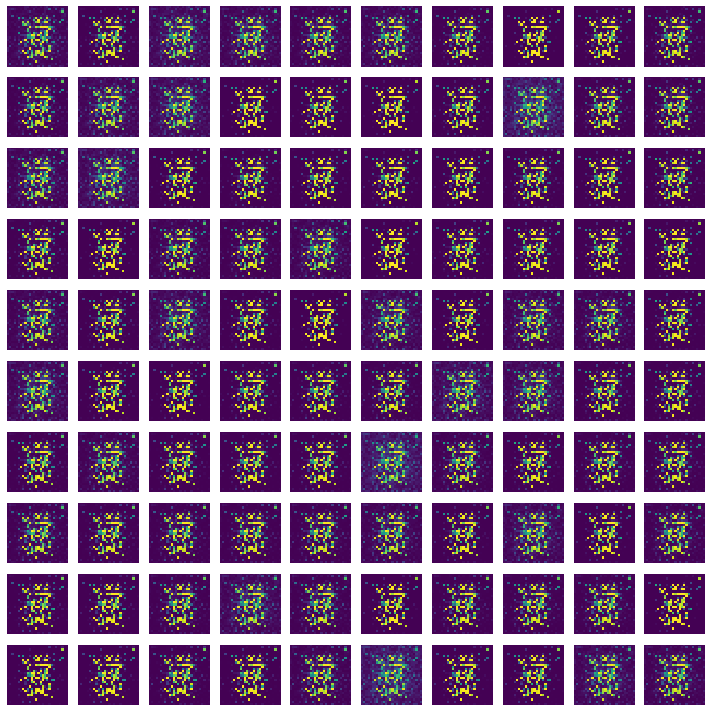

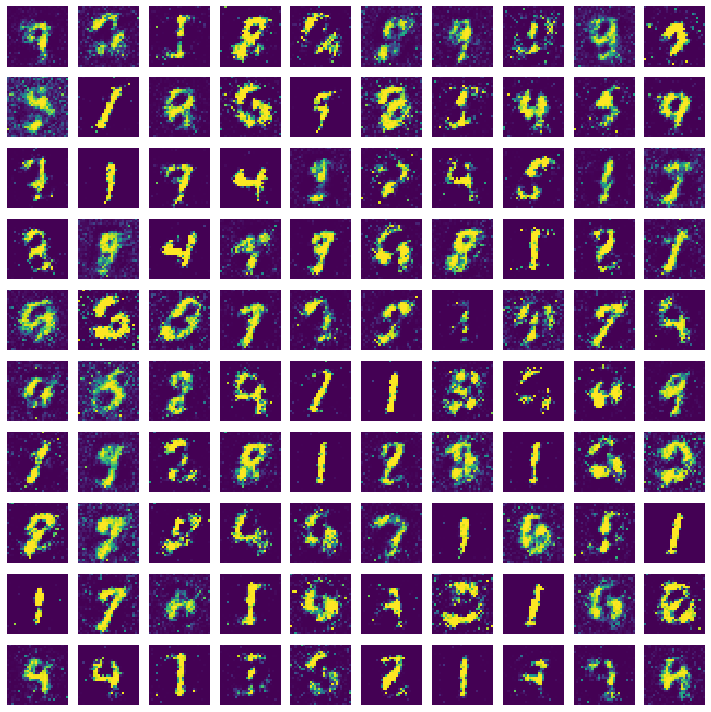

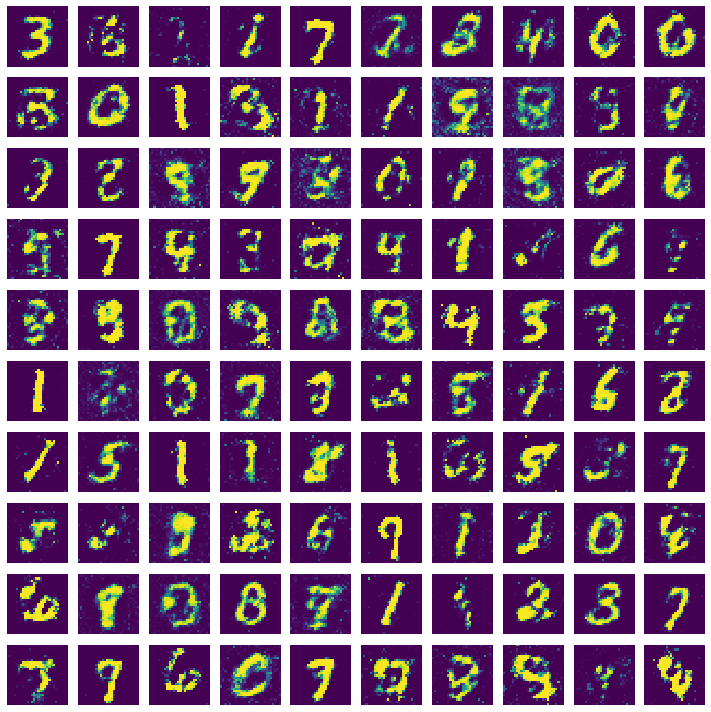

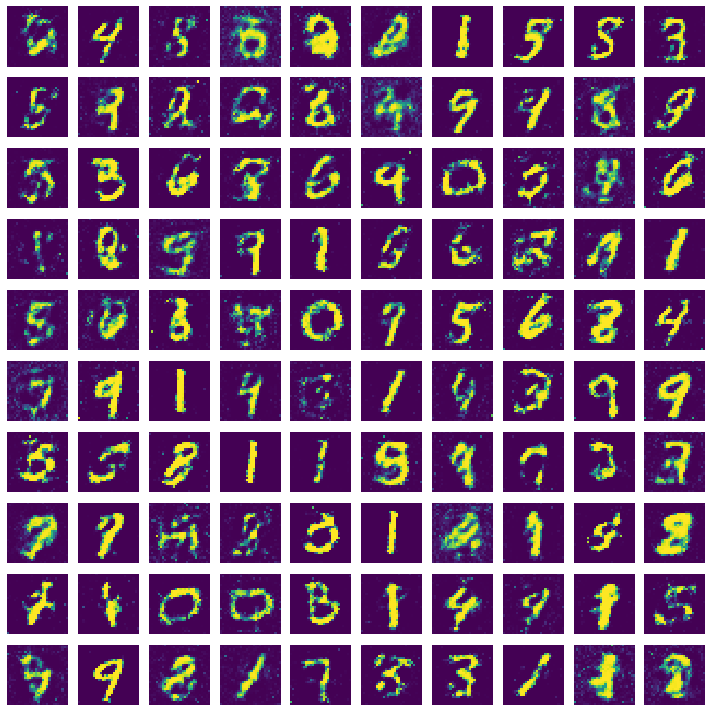

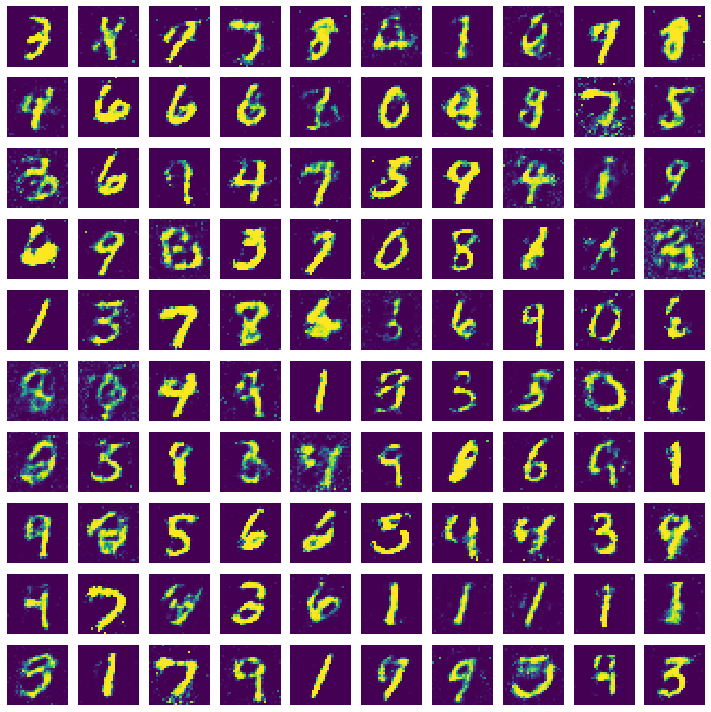

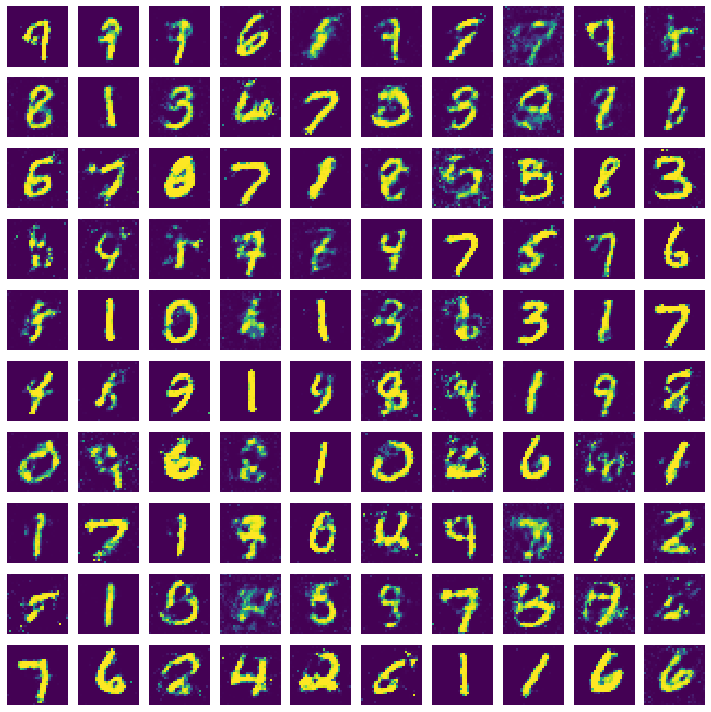

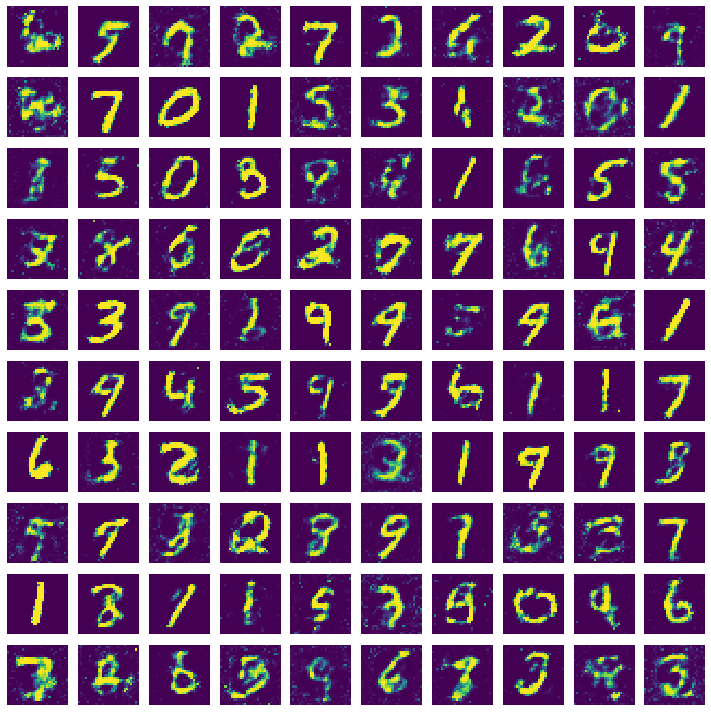

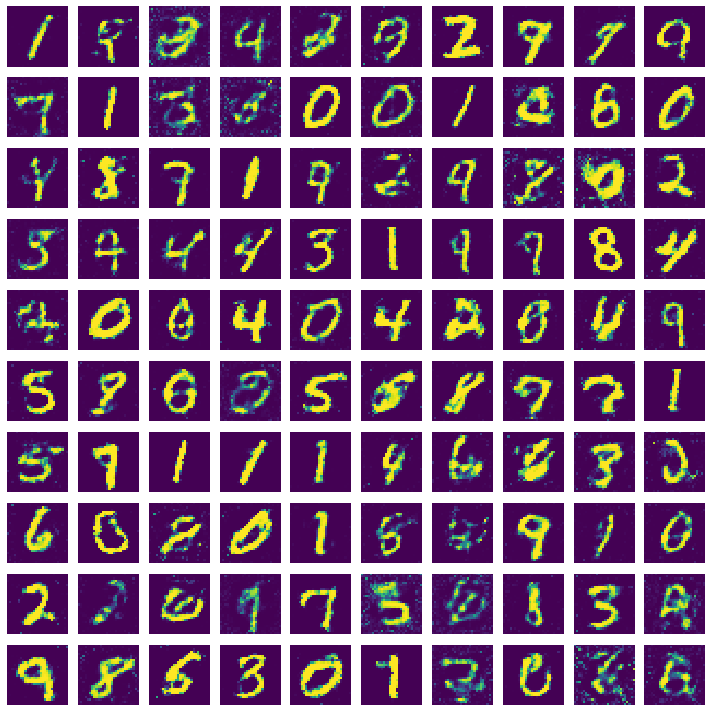

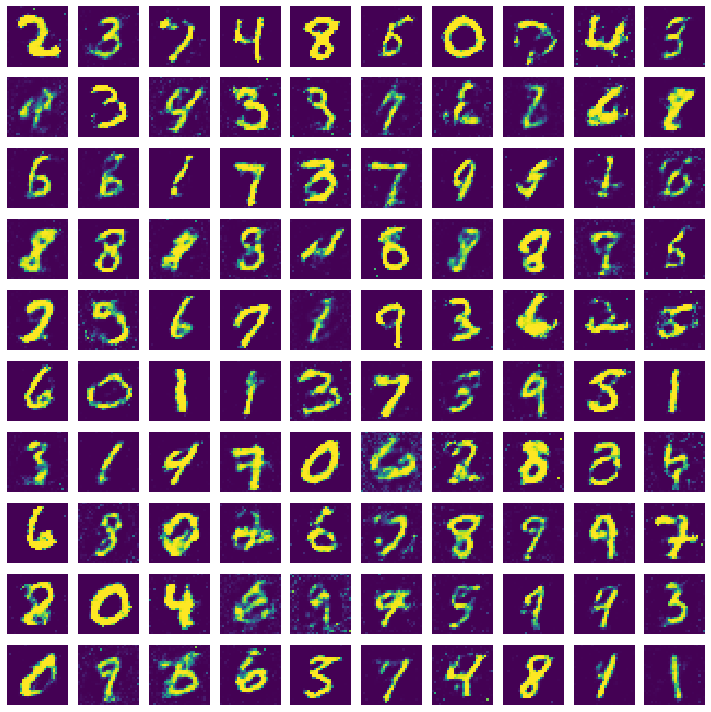

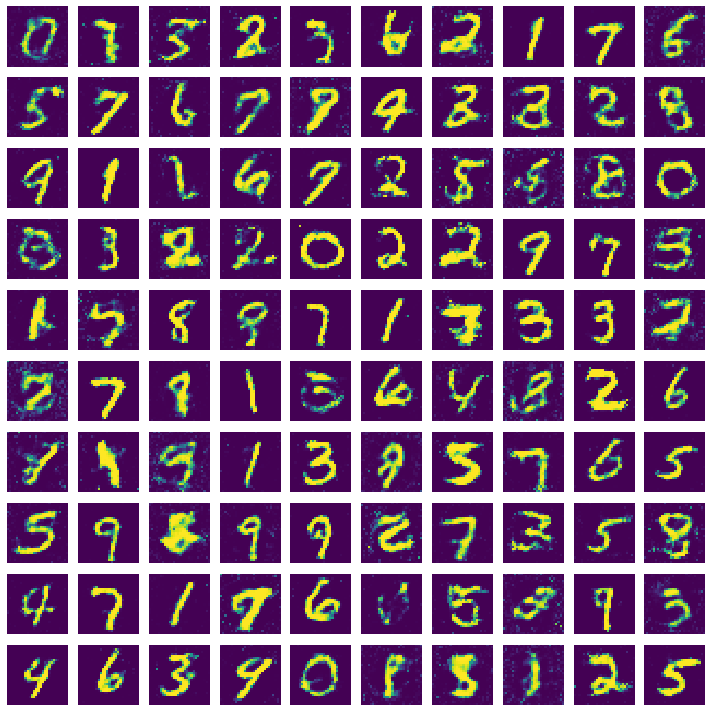

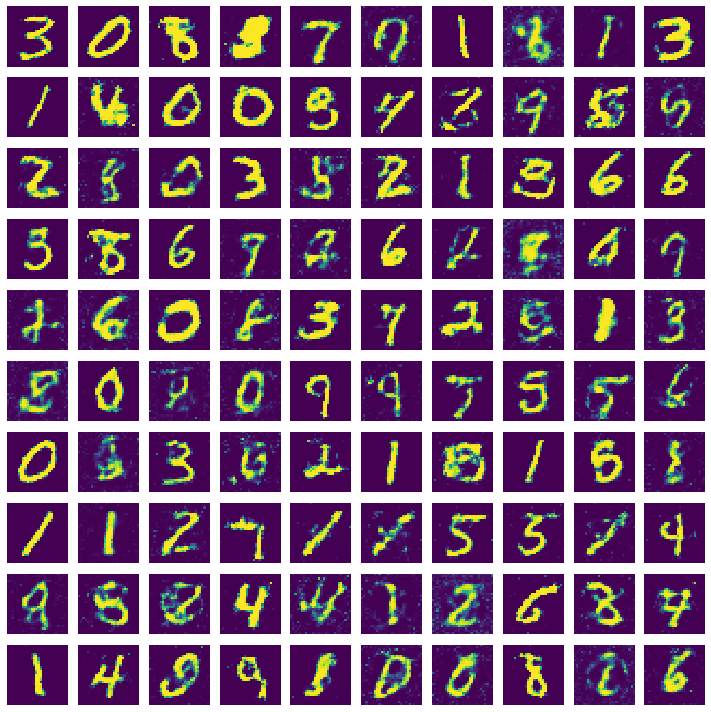

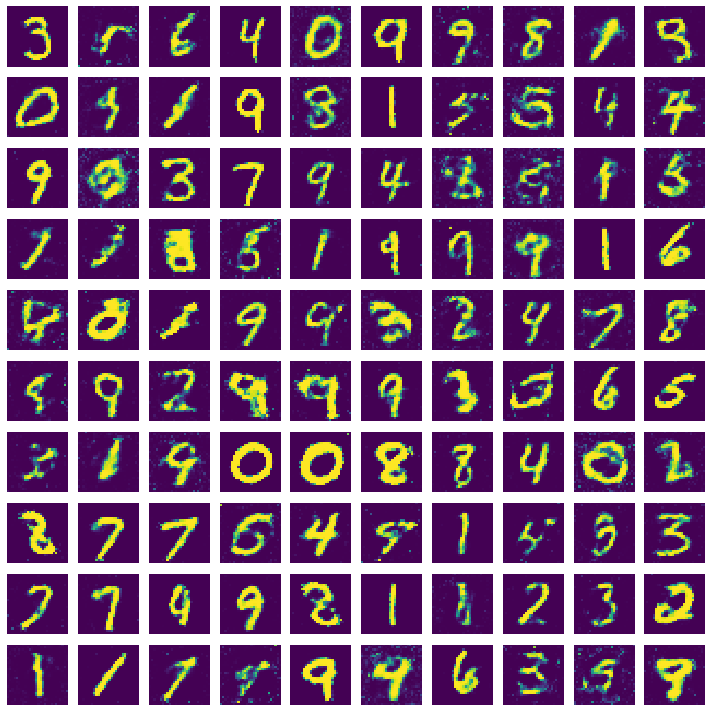

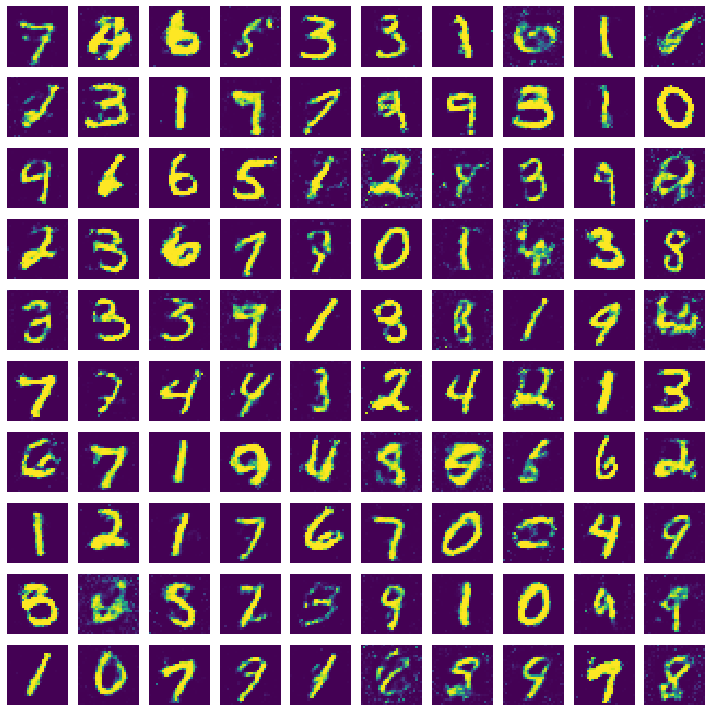

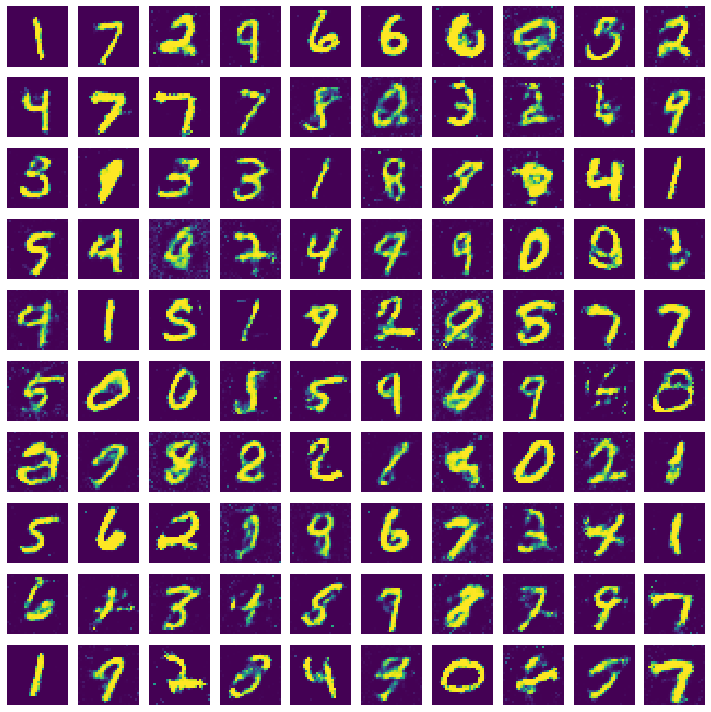

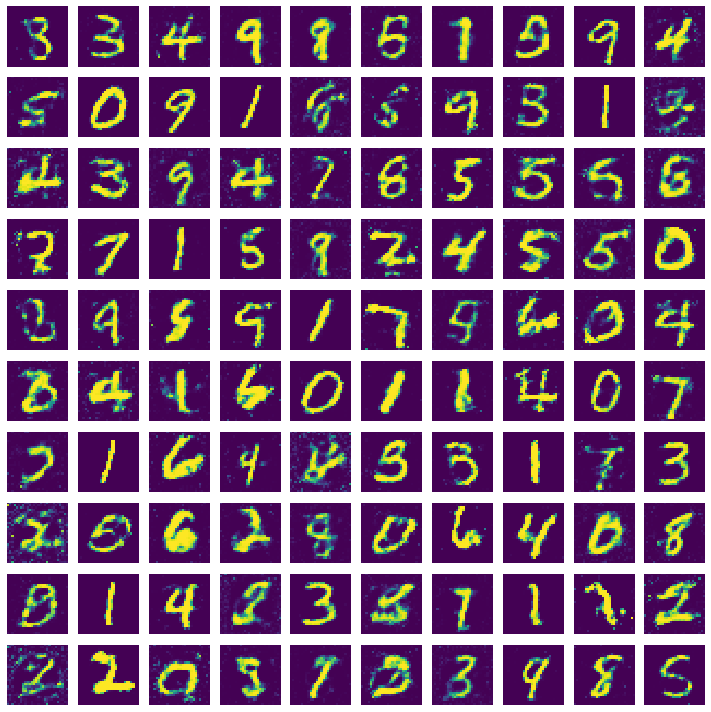

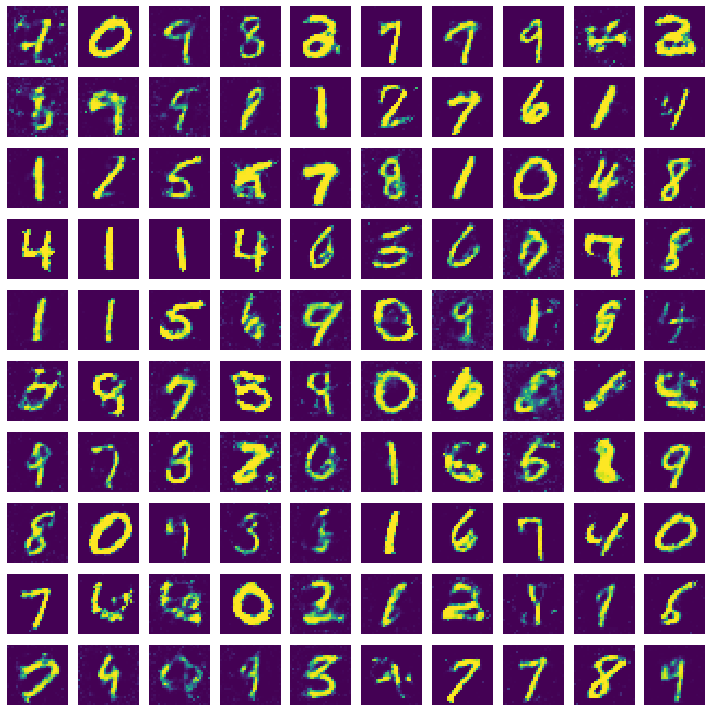

In [8]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
            
training(300,128)